# California Housing Price Project With Pycaret

## Table of Contents

- [Data](#data)
- [Geospatial Data Treatment](#geospatial-data-treatment)
- [Create Feature For Stratified Train Test Split](#create-feature-for-stratified-train-test-split)
- [Pycaret Setup](#pycaret-setup)
- [Pycaret Train](#pycaret-train)
- [Tune Model](#tune-model)
  - [Scikit Learn](#scikit-learn)
  - [Optuna](#optuna)
  - [Compare Tuned Models](#compare-tuned-models)
- [Deployment](#deployment)
  - [Finalize Model](#finalize-model)
  - [AWS S3](#aws-s3)
- [Predictions](#predictions)
- [Track Experiment Via MLflow](#track-experiment-via-mlflow)


## Data <a class="anchor" id="data"></a>

In [1]:
# Pycaret
from pycaret.regression import *

# Data wrangling, utils, and standard library
import numpy as np
import pandas as pd
import os
from joblib import dump
from typing import List, Optional

# Machine learning
from kneed import KneeLocator
from yellowbrick.cluster.elbow import distortion_score
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
import mlflow

# Plotting
from matplotlib.pyplot import scatter, grid, show, rcParams
from matplotlib.collections import PathCollection

# Interact session
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
# Read in raw data
def read_housing_csv(path='/Users/kenwu/Desktop/Python/Python for Machine Learning/california_housing_price_project/dataset/housing.csv'):
    return pd.read_csv(
        path,
        header="infer",
        index_col=None
    )
housing_data = read_housing_csv()
housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## Geospatial Data Treatment <a class="anchor" id="geospatial-data-treatment"></a>

To cluster the data based on the longitude and latitude columns, we create a custom transformer:

In [9]:
class CoordinateTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer for handling coordinate data. This transformer creates a column of cluster labels
    using the `sklearn.cluster.KMeans` learning algorithm that may be used in training in lieu of the original 
    coordinate data.


    Parameters
    ----------
    coord_cols : List[str], optional
        A list of columns containing coordinate data, by default ["longitude", "latitude"].
    strategy : str, optional
        The trategy for creating clustering labels, by default "kmeans".
    k_range : range, optional
        The range of value for the `n_clusters` parameter in `sklearn.cluster.KMeans` to try in order to determine an optimal value, by default range(4, 13).

    Attributes
    ----------
    distortion_scores_ : List[float]
        A list of mean distortions for each run of `sklearn.cluster.KMeans`. The distortion is computed as the the sum of the squared distances between each observation and 
        its closest centroid. Logically, this is the metric that K-Means attempts to minimize as it is fitting the model.
    optimal_k_: int
        The the optimal number of clusters.
    kmeans_: object
        An instance of `sklearn.cluster.KMeans` fitted with the optimal number of clusters as its `n_clusters` parameter.
    labels_: ndarray of shape (n_samples,)
        The labels of each point.
    """

    def __init__(self, coord_cols: List[str] = ["longitude", "latitude"], strategy: str = "kmeans", k_range: range = range(4, 13)) -> None:
        self.coord_cols = coord_cols
        self.strategy = strategy
        self.k_range = k_range

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        """
        Fit the transformer on X.

        Parameters
        ----------
        X : pd.DataFrame
            A pandas DataFrame.
        y : Optional[pd.Series], optional
            Ignored, present here for API consistency by convention, by default None.

        Returns
        -------
        self : object
            A fitted estimator.
        """
        # Input validate, convert coordinate columns to ndarray
        X_coords = check_array(
            X[self.coord_cols], accept_sparse=False, dtype="numeric")

        # Multiple runs
        distortion_scores = []
        for k in self.k_range:
            model = KMeans(n_clusters=k)
            model.fit_transform(X_coords)
            distortion_scores.append(distortion_score(X_coords, model.labels_))

        # Distortion scores
        self.distortion_scores_ = distortion_scores
        # Optimal number of clusters
        self.optimal_k_ = KneeLocator(
            x=self.k_range, y=self.distortion_scores_, curve='convex', direction='decreasing', S=1).knee

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transform input DataFrame by creating a column of cluster labels.

        Parameters
        ----------
        X : pd.DataFrame
            A pandas DataFrame.

        Returns
        -------
        pd.DataFrame
            A pandas DataFrame containing a new column 'kmean_cluster_labels'.
        """
        # Check that the fit method has been called
        check_is_fitted(self, ('distortion_scores_', 'optimal_k_'))

        # Input validation
        X_coords = check_array(
            X[self.coord_cols], accept_sparse=False, dtype="numeric")

        # Model
        self.kmeans_ = KMeans(n_clusters=self.optimal_k_, init='k-means++')

        # Store cluster labels as an attribute of the instance
        self.labels_ = self.kmeans_.fit_predict(X_coords)

        X['kmean_cluster_labels'] = self.labels_

        return X

    def plot(self, X: pd.DataFrame) -> PathCollection:
        """
        Generate a scatter plot of coordinate points with marker colors representing
        the cluster to which each data point belongs. This method should only be called
        once the transformation has completed, i.e., after `transform` or `fit_transform`.

        Parameters
        ----------
        X : pd.DataFrame
            A pandas DataFrame.

        Returns
        -------
        PathCollection
            A collection of Paths, as created by `matplotlib.pyplot.scatter`.

        Raises
        ------
        AttributeError
            The 'labels_' field is created only after `transform` is called.
        """
        if not hasattr(self, 'labels_'):
            raise AttributeError(
                "This 'CoordinateTransformer' instance is not transformed yet; please call 'transform' with appropriate arguments before plotting")

        return scatter(x=X[self.coord_cols[0]], y=X[self.coord_cols[1]],
                       c=self.labels_, s=50, cmap='viridis')

Use the transformer to generate a column of cluster labels:

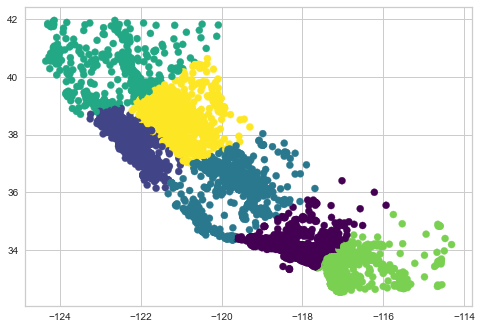

In [20]:
# Instantiate
transformer = CoordinateTransformer()
# Fit and transform
transformer.fit_transform(housing_data)
# Plot
transformer.plot(housing_data)

In [21]:
# Remove original longitude and latitude columns
housing_data.drop(columns=['longitude', 'latitude'], inplace=True)
housing_data.rename(columns={'kmean_cluster_labels': 'long_lat_cluster'}, inplace=True)
housing_data

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,kmean_cluster_labels
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,1
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,1
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,1
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,1
...,...,...,...,...,...,...,...,...,...
20635,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,5
20636,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,5
20637,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,5
20638,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,5


## Create Feature For Stratified Train Test Split <a class="anchor" id="create-feature-for-stratified-train-test-split"></a>

In [23]:
# Create a factor
housing_data["income_cat"] = pd.cut(
    # Input to be binned (arbitrarily selected)
    x=housing_data["median_income"],
    # Sequence of scalars for bin edges
    bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
    # Bin lables for each returned bins
    labels=[1, 2, 3, 4, 5]
)
housing_data

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,kmean_cluster_labels,income_cat
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,1,5
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1,5
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,1,5
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,1,4
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,1,3
...,...,...,...,...,...,...,...,...,...,...
20635,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,5,2
20636,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,5,2
20637,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,5,2
20638,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,5,2


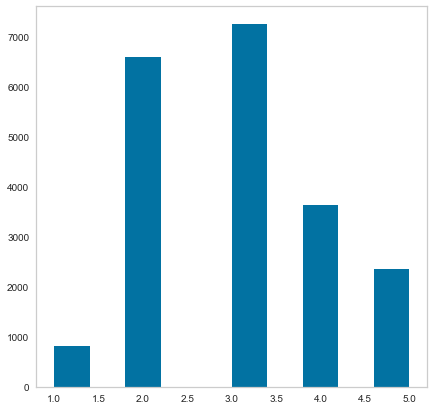

In [28]:
# Figure size
rcParams['figure.figsize'] = [7, 7]
# Hisgrogram 
housing_data.income_cat.hist()
grid(False)
show()

## Pycaret Setup <a class="anchor" id="pycaret-setup"></a>

The following preprocessing steps are done by default:

* PyCaret by default imputes the missing value in the dataset by `mean` for numeric features and a `constant` 'not_available' for categorical features. To change the imputation method, `numeric_imputation` and `categorical_imputation` parameters can be used within the setup. 

* One-Hot Encoding will take place for all features that are either inferred as categorical or are forced as categorical using `categorical_features` in the setup function.

* Train-test split can be controlled further via the following setup parameters:

    * train_size: float, default = 0.7 
      * The proportion of the dataset to be used for training and validation. 

    * test_data: pandas.DataFrame, default = None
      * If not None, the test_data is used as a hold-out set and the train_size is ignored. test_data must be labeled and the shape of the data and test_data must match.

    * data_split_shuffle: bool, default = True
      * When set to False, prevents shuffling of rows during train_test_split.

    * data_split_stratify: bool or list, default = False
      * Controls stratification during the train_test_split. When set to True, it will stratify by target column. To stratify on any other columns, pass a list of column names. Ignored when data_split_shuffle is False.
    
    * fold_strategy: str or scikit-learn CV generator object, default = ‘stratifiedkfold’
      * Choice of cross-validation strategy. Possible values are:
          * ‘kfold’
          * ‘stratifiedkfold’
          * ‘groupkfold’
          * ‘timeseries’
          * a custom CV generator object compatible with scikit-learn.
    
    * fold: int, default = 10
      * The number of folds to be used in cross-validation. Must be at least 2. This is a global setting that can be over-written at the function level by using the fold parameter. Ignored when fold_strategy is a custom object.

    * fold_shuffle: bool, default = False
      * Controls the shuffle parameter of CV. Only applicable when fold_strategy is kfold or stratifiedkfold. Ignored when fold_strategy is a custom object.

    * fold_groups: str or array-like, with shape (n_samples,), default = None
      * Optional group labels when ‘GroupKFold’ is used for the cross-validation. It takes an array with shape (n_samples, ) where n_samples is the number of rows in the training dataset. When the string is passed, it is interpreted as the column name in the dataset containing group labels.

In [40]:
# Initialized training environment
setup(
    data=housing_data,
    target='median_house_value',
    train_size=0.8,
    preprocess=True,
    numeric_features=['long_lat_cluster'],
    # The other approach is 'iterative', which defines a function that predicts missing values from non-missing values
    imputation_type='simple',
    numeric_imputation='median',
    # Missing values in categorical features are imputed with a constant 'not_available' value
    categorical_imputation='constant',
    # Controls for train_test_split
    data_split_shuffle = True,
    data_split_stratify=['income_cat'],
    fold_strategy='kfold',
    fold_shuffle=True,
    # Normalization
    normalize=True,
    normalize_method='robust',
    # Transformation (defaults to box-cox power transformation)
    transformation=True,
    transformation_method='yeo-johnson',
    # Target is right-skewed (box-cox for all positive targe values and 'yeo-johnson' if target contains negative values)
    transform_target=True,
    transform_target_method='box-cox',
    # Interactions and polynomial features
    feature_interaction=True,
    feature_ratio=True,
    # The lower the fewer interaction and ratio features are kept
    interaction_threshold=0.01,
    polynomial_features=True,
    polynomial_degree=2,
    polynomial_threshold=0.01,
    # Feature selection
    feature_selection=True,
    feature_selection_threshold=0.8,
    # Use 'boruta' algorithm for feature selection
    feature_selection_method='boruta',
    remove_multicollinearity=True,
    multicollinearity_threshold=0.8,
    # Experiment control
    session_id=1227,
    log_experiment='mlflow',
    experiment_name='california_housing',
    log_data=True
)

,Description,Value
0,session_id,1227
1,Target,median_house_value
2,Original Data,"(20640, 10)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(16512, 8)"


(1227,
 {'mae': <pycaret.containers.metrics.regression.MAEMetricContainer at 0x13741dbe0>,
  'mse': <pycaret.containers.metrics.regression.MSEMetricContainer at 0x13741d6d0>,
  'rmse': <pycaret.containers.metrics.regression.RMSEMetricContainer at 0x13741d940>,
  'r2': <pycaret.containers.metrics.regression.R2MetricContainer at 0x13741d700>,
  'rmsle': <pycaret.containers.metrics.regression.RMSLEMetricContainer at 0x13741d2e0>,
  'mape': <pycaret.containers.metrics.regression.MAPEMetricContainer at 0x13741d8e0>},
 'lightgbm',
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'dashboard_logger',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_groups_param_full',
  'fold_param',


## Pycaret Train <a class="anchor" id="pycaret-train"></a>

In [52]:
# Examine all models available
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [54]:
best_models = compare_models(n_select=3, include=['svm', 'knn', 'gbr', 'lightgbm', 'rf', 'br'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,44588.3529,4331394156.0692,65760.8348,0.6724,0.3029,0.2330,0.0550
gbr,Gradient Boosting Regressor,45748.4938,4503973446.8729,67052.4562,0.6594,0.3069,0.2377,0.4560
svm,Support Vector Regression,44594.5723,4539252699.6377,67317.5746,0.6568,0.3077,0.2253,2.1780
rf,Random Forest Regressor,46617.2293,4654012866.8944,68171.7709,0.6480,0.3172,0.2463,1.2240
knn,K Neighbors Regressor,48089.5303,4911228620.6343,70036.7468,0.6285,0.3274,0.2530,0.0300
br,Bayesian Ridge,51543.4143,5283411156.5939,72641.6517,0.6005,0.3363,0.2687,0.0190


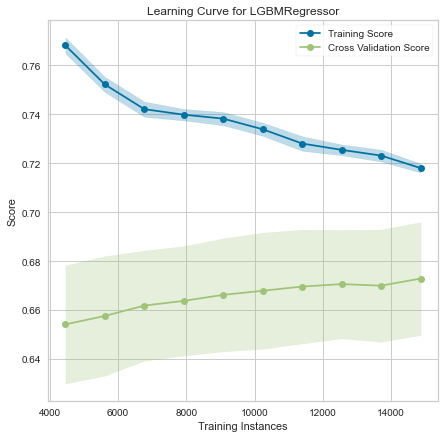

In [81]:
plot_model(best_models[0], 'learning')

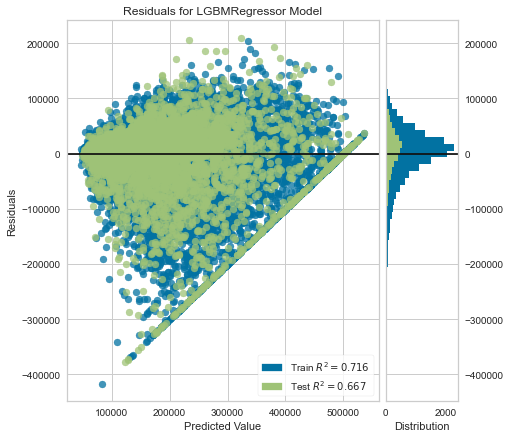

In [84]:
plot_model(best_models[0], 'residuals')

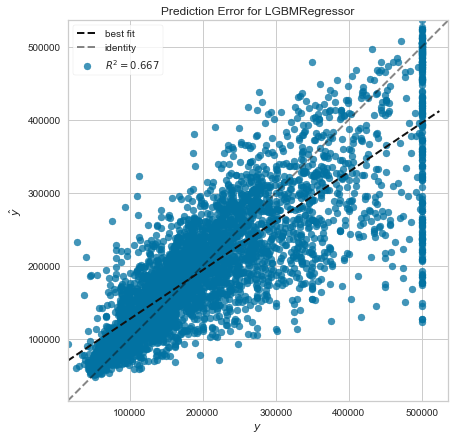

In [85]:
plot_model(best_models[0], 'error')

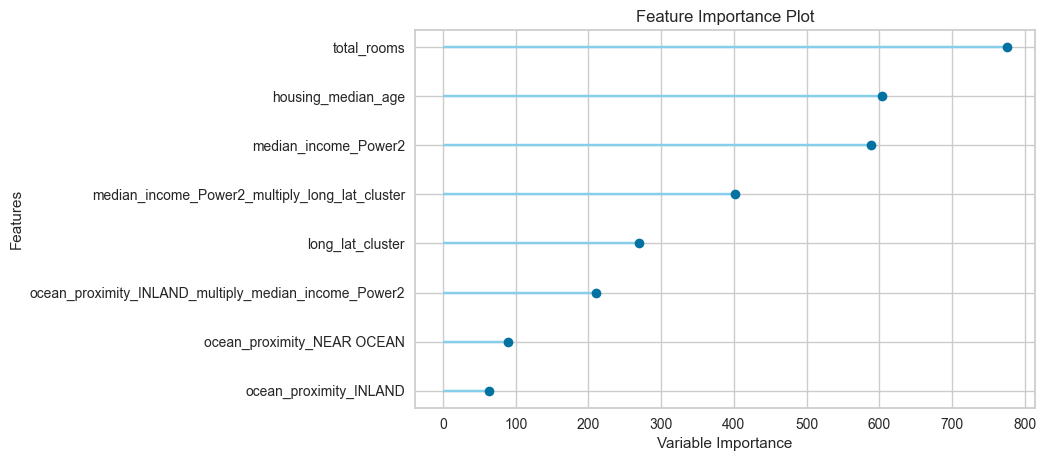

In [87]:
plot_model(best_models[0], 'feature')

## Tune Model <a class="anchor" id="tune-model"></a>

### Scikit Learn <a class="anchor" id="scikit-learn"></a>

In [89]:
tuned_gbdt = tune_model(
    estimator=best_models[0],
    n_iter=50,
    search_algorithm='random',
    optimize='R2'
)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,45286.0292,4415453022.6425,66448.8753,0.6722,0.3064,0.2365
1,45322.0165,4360736571.1295,66035.8734,0.6751,0.3021,0.2310
2,45803.6974,4514457742.3274,67189.7146,0.6610,0.2973,0.2308
3,41933.5765,3637568453.8243,60312.2579,0.7004,0.2940,0.2330
4,44646.6712,4281352113.2273,65432.0419,0.6583,0.3046,0.2359
5,43817.6073,4058429876.9087,63705.8072,0.6842,0.2995,0.2296
6,45278.6521,4534554219.9154,67339.0987,0.6821,0.3110,0.2390
7,44763.9941,4381687506.2277,66194.3163,0.6907,0.3079,0.2348
8,47004.2095,4816936634.0068,69404.1543,0.6355,0.3039,0.2340


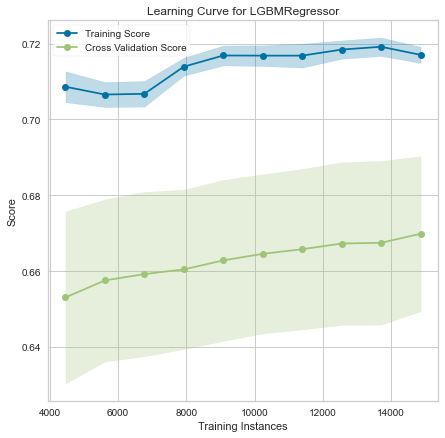

In [96]:
plot_model(tuned_gbdt, 'learning')

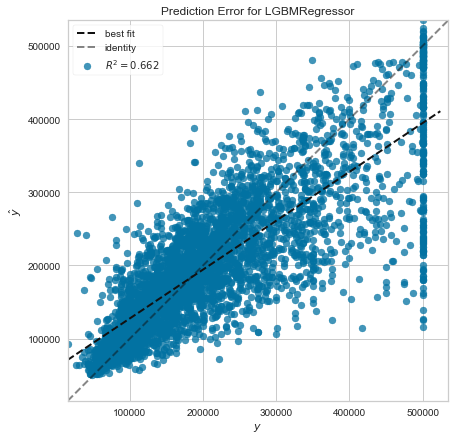

In [98]:
plot_model(tuned_gbdt, 'error')

### Optuna <a class="anchor" id="optuna"></a>

In [101]:
tuned_gbdt_optuna = tune_model(
    estimator=best_models[0],
    n_iter=50,
    search_library='optuna'
)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,45418.2923,4449335523.5492,66703.3397,0.6696,0.3066,0.2368
1,45259.7962,4354012085.2888,65984.9383,0.6756,0.3005,0.2302
2,45378.9908,4492131624.9715,67023.3663,0.6626,0.2958,0.2287
3,41899.9515,3644630519.7838,60370.7754,0.6998,0.2928,0.2326
4,44215.2628,4234922352.2689,65076.2810,0.6620,0.3016,0.2328
5,43772.7737,4028458382.4963,63470.1377,0.6865,0.2965,0.2285
6,45094.5001,4518495179.5773,67219.7529,0.6832,0.3089,0.2380
7,44522.7762,4297383458.3089,65554.4313,0.6967,0.3036,0.2325
8,46776.6787,4804152553.3411,69311.9943,0.6364,0.3021,0.2330


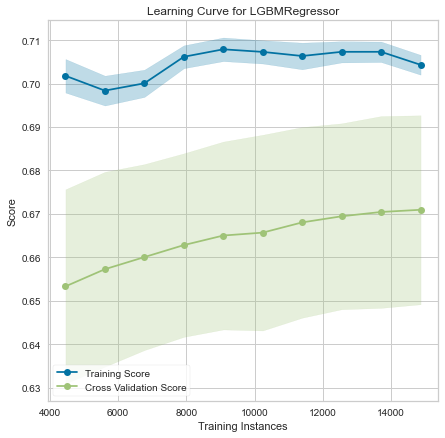

In [103]:
plot_model(tuned_gbdt_optuna, 'learning')

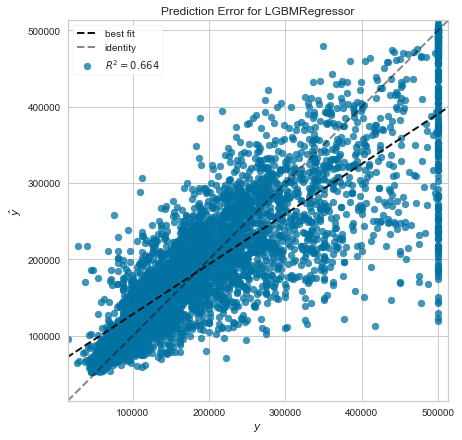

In [104]:
plot_model(tuned_gbdt_optuna, 'error')

### Compare Tuned Models <a class="anchor" id="compare-tuned-models"></a>

In [126]:
plot_model(tuned_gbdt_optuna, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.05358375462927027
max_depth,-1
min_child_samples,45
min_child_weight,0.001
min_split_gain,0.7269152106826471
n_estimators,241


In [127]:
plot_model(tuned_gbdt, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.2
max_depth,-1
min_child_samples,81
min_child_weight,0.001
min_split_gain,0.2
n_estimators,200


## Deployment <a class="anchor" id="Deployment"></a>

### Finalize Model <a class="anchor" id="finalize-model"></a>

In [130]:
final_gbdt = finalize_model(tuned_gbdt_optuna)

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8416720479483181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8416720479483181
[LightGBM] [Warning] bagging_fraction is set=0.687768393451885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.687768393451885
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8416720479483181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8416720479483181
[LightGBM] [Warning] bagging_fraction is set=0.687768393451885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.687768393451885
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8416720479483181, colsample_byt

In [133]:
# Load with load_model('../models/tuned_gbdt.pkl')
save_model(final_gbdt, '../models/final_gbdt.pkl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['long_lat_cluster'],
                                       target='median_house_value',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_nu...
                                                                          min_child_weight=0.001,
                                                                          min_split_gain=0.7269152106826471,
                                                                          n_estimators=241,
         

In [129]:
# Load with load_config('../processing/pycaret_setup_config.pkl')
save_config('../processing/pycaret_setup_config.pkl')

### AWS S3 <a class="anchor" id="aws-s3"></a>

In [12]:
deploy_model(model = final_gbdt, model_name = 'gbdt-for_deployment', platform = 'aws', authentication = {'bucket' : 'mlmodelsbucket'})

Model Successfully Deployed on AWS S3


## Predictions <a class="anchor" id="predictions"></a>

In [135]:
X = housing_data.copy()
X.drop(columns=['median_house_value'], inplace=True)

In [142]:
# Predict
predictions_gbdt = predict_model(final_gbdt)
predictions_gbdt

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,42993.9913,4161221611.2065,64507.5314,0.6941,0.2886,0.2199


,housing_median_age,total_rooms,long_lat_cluster,median_income_Power2,ocean_proximity_INLAND,ocean_proximity_NEAR OCEAN,ocean_proximity_INLAND_multiply_median_income_Power2,median_income_Power2_multiply_long_lat_cluster,median_house_value,Label
0,-1.746912,0.020138,1.551678,0.075612,1.0,0.0,0.075612,0.117325,147600.0,138994.184436
1,0.592200,-0.233639,-1.021398,1.845685,0.0,0.0,0.000000,-1.885180,500001.0,472204.575863
2,0.980275,-1.049124,-1.021398,-1.179170,0.0,0.0,-0.000000,1.204402,124300.0,137403.583187
3,-0.277549,0.105978,-1.021398,1.303062,0.0,0.0,0.000000,-1.330945,254900.0,281210.859216
4,0.592200,-0.428143,0.121082,0.120569,0.0,0.0,0.000000,0.014599,159600.0,197022.036317
...,...,...,...,...,...,...,...,...,...,...
4123,0.041660,0.763002,-1.021398,1.129680,0.0,0.0,0.000000,-1.153853,316900.0,293282.375610
4124,-1.006444,1.007132,0.121082,1.498977,0.0,0.0,0.000000,0.181498,299300.0,323998.403496
4125,-0.519016,-0.431236,1.551678,-1.279091,1.0,0.0,-1.279091,-1.984737,63000.0,87410.438961
4126,0.041660,-0.340336,-1.021398,1.775922,0.0,0.0,0.000000,-1.813923,500001.0,437636.509629


In [144]:
# Serialize predictions arrays
dump(predictions_gbdt, "../predictions/gbdt_predictions.pkl")

['../predictions/gbdt_predictions.pkl']

## Track Experiment Via MLflow <a class="anchor" id="track-experiment-via-mlflow"></a>

In [13]:
# init server
!mlflow ui

[2022-05-08 02:02:03 -0400] [62377] [INFO] Starting gunicorn 20.1.0
[2022-05-08 02:02:03 -0400] [62377] [INFO] Listening at: http://127.0.0.1:5000 (62377)
[2022-05-08 02:02:03 -0400] [62377] [INFO] Using worker: sync
[2022-05-08 02:02:03 -0400] [62378] [INFO] Booting worker with pid: 62378
[2022-05-08 02:03:46 -0400] [62377] [CRITICAL] WORKER TIMEOUT (pid:62378)
[2022-05-08 02:03:46 -0400] [62378] [INFO] Worker exiting (pid: 62378)
[2022-05-08 02:03:47 -0400] [62525] [INFO] Booting worker with pid: 62525
^C
[2022-05-08 02:06:16 -0400] [62377] [INFO] Handling signal: int
[2022-05-08 02:06:16 -0400] [62525] [INFO] Worker exiting (pid: 62525)
